In [1]:
import torch
import torchvision
import sys
sys.path.append('..')
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


/mnt/cfs/home/saachij/conda_envs/ffcv_cfs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training the base model

First, we're going to train a CIFAR-10 model. We just put an example setup here (make sure to evaluate these cells, but feel free to skip to the next section for our method!)

### Setting up the dataset
Ok, first let's set up the dataset. We're going to use CIFAR-10, so let's download it below.

We are going to train on 20% of the training dataset, and will let another 20% be validation. 

In [2]:
hparams = {
    'mean': [125.307, 122.961, 113.8575], 'std': [51.5865, 50.847, 51.255],
    'num_classes': 10, 'arch': 'resnet18', 'arch_type': 'cifar_resnet', 'batch_size': 512,
    'training': {
        'epochs': 35, 'lr': 0.5,
        'optimizer': {'momentum': 0.9, 'weight_decay': 5.0E-4},
        'lr_scheduler':{'type': 'cyclic', 'lr_peak_epoch': 5}
    }
}

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])

In [3]:
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

all_train_indices = torch.arange(len(orig_train_ds))
val_indices = all_train_indices[::5]
train_indices = all_train_indices[1::5]

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

In [4]:
bsz = hparams['batch_size']
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)

loaders = {'train': no_aug_train_loader, 'test': test_loader, 'val': val_loader} 

### Training a Model
Ok, let's train a model. We'll train a ResNet-18. 

if you've already trained the model by running the cells below, load it here:

In [5]:
# if you've already trained the model just load it here
build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
path = "runs/temp/version_0/checkpoints/checkpoint_best.pt"
model = failure_directions.model_utils.load_model(path, build_fn)
model = model.cuda()


{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 78}, 'epoch': 34, 'training_metrics': {'loss': 0.023533763614698097, 'acc': 0.9933894230769231}, 'val_metrics': {'loss': 0.23021368625164032, 'acc': 0.9349000001907348}}


otherwise, train it below

In [6]:
build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
model = build_fn(hparams['arch'], hparams['num_classes'])
model = model.cuda()

training_args=hparams['training']
training_args['iters_per_epoch'] = len(train_loader)
trainer = failure_directions.LightWeightTrainer(training_args=hparams['training'],
                                                exp_name='temp', enable_logging=True,
                                                bce=False, set_device=True)
trainer.fit(model, train_loader, val_loader)

logging in  runs/temp/version_1


Val Epoch: 0: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, loss=252, acc=0.0846]


LR: 0.09999999999999999, Train Loss: 2.5219, Train Acc: 0.1819, Val Loss: 270.7297, Val Acc: 0.0976


Val Epoch: 1: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=88.9, acc=0.147] 


LR: 0.19999999999999998, Train Loss: 2.1982, Train Acc: 0.2343, Val Loss: 100.4954, Val Acc: 0.1063


Val Epoch: 2: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s, loss=2.37, acc=0.287]


LR: 0.3, Train Loss: 1.9406, Train Acc: 0.2879, Val Loss: 2.5132, Val Acc: 0.2525


Val Epoch: 3: 100%|██████████| 20/20 [00:03<00:00,  5.92it/s, loss=1.83, acc=0.305]


LR: 0.39999999999999997, Train Loss: 1.7765, Train Acc: 0.3356, Val Loss: 1.9089, Val Acc: 0.3027


Val Epoch: 4: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, loss=1.72, acc=0.386]


LR: 0.5, Train Loss: 1.6646, Train Acc: 0.3778, Val Loss: 1.7914, Val Acc: 0.3540


Val Epoch: 5: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, loss=1.57, acc=0.412]


LR: 0.48333333333333334, Train Loss: 1.5971, Train Acc: 0.4081, Val Loss: 1.6344, Val Acc: 0.3827


Val Epoch: 6: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s, loss=1.53, acc=0.408]


LR: 0.4666666666666667, Train Loss: 1.5526, Train Acc: 0.4275, Val Loss: 1.6183, Val Acc: 0.3993


Val Epoch: 7: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, loss=1.55, acc=0.445]


LR: 0.45, Train Loss: 1.4697, Train Acc: 0.4581, Val Loss: 1.6029, Val Acc: 0.4154


Val Epoch: 8: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s, loss=1.63, acc=0.452]


LR: 0.43333333333333335, Train Loss: 1.4047, Train Acc: 0.4889, Val Loss: 1.6849, Val Acc: 0.4083


Val Epoch: 9: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s, loss=1.42, acc=0.504]


LR: 0.4166666666666667, Train Loss: 1.3498, Train Acc: 0.5043, Val Loss: 1.4917, Val Acc: 0.4542


Val Epoch: 10: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s, loss=1.47, acc=0.482]


LR: 0.4, Train Loss: 1.2689, Train Acc: 0.5408, Val Loss: 1.4717, Val Acc: 0.4688


Val Epoch: 11: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s, loss=1.21, acc=0.588]


LR: 0.3833333333333333, Train Loss: 1.2016, Train Acc: 0.5610, Val Loss: 1.3166, Val Acc: 0.5397


Val Epoch: 12: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s, loss=1.39, acc=0.504]


LR: 0.3666666666666667, Train Loss: 1.1174, Train Acc: 0.5976, Val Loss: 1.5291, Val Acc: 0.4886


Val Epoch: 13: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s, loss=1.22, acc=0.577]


LR: 0.35, Train Loss: 1.0515, Train Acc: 0.6189, Val Loss: 1.3091, Val Acc: 0.5446


Val Epoch: 14: 100%|██████████| 20/20 [00:03<00:00,  5.97it/s, loss=1.23, acc=0.559]


LR: 0.33333333333333337, Train Loss: 1.0009, Train Acc: 0.6375, Val Loss: 1.2614, Val Acc: 0.5574


Val Epoch: 15: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, loss=1.06, acc=0.64] 


LR: 0.31666666666666665, Train Loss: 0.9534, Train Acc: 0.6574, Val Loss: 1.1203, Val Acc: 0.5925


Val Epoch: 16: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s, loss=0.99, acc=0.669] 


LR: 0.3, Train Loss: 0.9397, Train Acc: 0.6625, Val Loss: 1.0691, Val Acc: 0.6294


Val Epoch: 17: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s, loss=1.01, acc=0.643] 


LR: 0.2833333333333333, Train Loss: 0.8760, Train Acc: 0.6906, Val Loss: 1.0793, Val Acc: 0.6246


Val Epoch: 18: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s, loss=0.916, acc=0.676]


LR: 0.26666666666666666, Train Loss: 0.8251, Train Acc: 0.7086, Val Loss: 1.0467, Val Acc: 0.6345


Val Epoch: 19: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s, loss=0.968, acc=0.673]


LR: 0.25, Train Loss: 0.7893, Train Acc: 0.7258, Val Loss: 1.0005, Val Acc: 0.6535


Val Epoch: 20: 100%|██████████| 20/20 [00:03<00:00,  6.10it/s, loss=0.952, acc=0.665]


LR: 0.23333333333333334, Train Loss: 0.7401, Train Acc: 0.7359, Val Loss: 1.0984, Val Acc: 0.6413


Val Epoch: 21: 100%|██████████| 20/20 [00:03<00:00,  6.04it/s, loss=0.796, acc=0.728]


LR: 0.21666666666666667, Train Loss: 0.6992, Train Acc: 0.7530, Val Loss: 0.9556, Val Acc: 0.6768


Val Epoch: 22: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s, loss=0.79, acc=0.743] 


LR: 0.2, Train Loss: 0.6488, Train Acc: 0.7706, Val Loss: 0.9454, Val Acc: 0.6817


Val Epoch: 23: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s, loss=0.881, acc=0.684]


LR: 0.18333333333333335, Train Loss: 0.6328, Train Acc: 0.7712, Val Loss: 1.0152, Val Acc: 0.6647


Val Epoch: 24: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s, loss=0.835, acc=0.728]


LR: 0.16666666666666669, Train Loss: 0.5984, Train Acc: 0.7861, Val Loss: 0.8644, Val Acc: 0.7035


Val Epoch: 25: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s, loss=0.663, acc=0.776]


LR: 0.14999999999999997, Train Loss: 0.5573, Train Acc: 0.7988, Val Loss: 0.8196, Val Acc: 0.7276


Val Epoch: 26: 100%|██████████| 20/20 [00:03<00:00,  6.00it/s, loss=0.704, acc=0.746]


LR: 0.1333333333333333, Train Loss: 0.5322, Train Acc: 0.8100, Val Loss: 0.8113, Val Acc: 0.7267


Val Epoch: 27: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s, loss=0.603, acc=0.794]


LR: 0.11666666666666664, Train Loss: 0.4816, Train Acc: 0.8258, Val Loss: 0.8378, Val Acc: 0.7334


Val Epoch: 28: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s, loss=0.792, acc=0.739]


LR: 0.09999999999999998, Train Loss: 0.4382, Train Acc: 0.8458, Val Loss: 0.8983, Val Acc: 0.7105


Val Epoch: 29: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=0.657, acc=0.812]


LR: 0.08333333333333331, Train Loss: 0.3840, Train Acc: 0.8627, Val Loss: 0.8182, Val Acc: 0.7471


Val Epoch: 30: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s, loss=0.767, acc=0.757]


LR: 0.06666666666666665, Train Loss: 0.3560, Train Acc: 0.8737, Val Loss: 0.8502, Val Acc: 0.7468


Val Epoch: 31: 100%|██████████| 20/20 [00:03<00:00,  6.03it/s, loss=0.614, acc=0.79] 


LR: 0.04999999999999999, Train Loss: 0.3200, Train Acc: 0.8872, Val Loss: 0.7739, Val Acc: 0.7618


Val Epoch: 32: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, loss=0.6, acc=0.812]  


LR: 0.033333333333333326, Train Loss: 0.2678, Train Acc: 0.9066, Val Loss: 0.7996, Val Acc: 0.7628


Val Epoch: 33: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=0.573, acc=0.827]


LR: 0.016666666666666663, Train Loss: 0.2493, Train Acc: 0.9138, Val Loss: 0.7564, Val Acc: 0.7687


Val Epoch: 34: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s, loss=0.57, acc=0.812] 


LR: 0.0, Train Loss: 0.2179, Train Acc: 0.9265, Val Loss: 0.7228, Val Acc: 0.7850


now let's evaluate the model and get the predictions!

In [7]:
def evaluate_model(loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

In [8]:
model = model.eval()
run_dict = {}
for split, loader in loaders.items():
    run_dict[split] = evaluate_model(loader) # gts, preds, confs

100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


# Bringing in CLIP

In [9]:
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'])

In [10]:
clip_features = {}
for split, loader in loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


# Fitting the SVM

In [11]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess(clip_features['train'])
val_gts, val_preds, _ = run_dict['val']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


In [12]:
svm_predictions = {}
svm_decision_values = {}
for split, loader in loaders.items():
    gts_, _, _ = run_dict[split]
    mask, dv = svm_fitter.predict(ys=gts_, latents=clip_features[split], compute_metrics=False)
    svm_predictions[split] = mask
    svm_decision_values[split] = dv

100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


## Captioning our failure modes!

In [13]:
from failure_directions.src.clip_utils import get_caption_set

In [14]:
captions = failure_directions.get_caption_set('CIFAR')

excluding great pyrenees
excluding doberman
excluding coondog
excluding ibizan hound
excluding malamute
excluding leonberg
excluding clumber
excluding liver-spotted dalmatian
excluding pekinese
excluding seizure-alert dog
excluding lapdog
excluding curly-coated retriever
excluding vizsla
excluding american staffordshire terrier
excluding bullterrier
excluding appenzeller
excluding belgian sheepdog
excluding sennenhunde
excluding rottweiler
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding norwich terrier
excluding shih-tzu
excluding bedlington terrier
excluding flat-coated retriever
excluding housedog
excluding entlebucher
excluding wire-haired fox terrier
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding blenheim spaniel
excluding smooth-haired fox terrier
excluding soft-coated wheaten terrier
excluding german short-haired pointer
excluding plott hound
excluding old english sheepdog
excluding shetland

 18%|█▊        | 2/11 [00:00<00:00, 13.12it/s]

dog
bird


100%|██████████| 11/11 [00:00<00:00, 50.91it/s]

automobile
airplane
truck
ship
frog
cat
horse
deer
reference


In [ ]:
selected_captions = []
for target_c in range(10):
    target_c_name = test_ds.classes[target_c]
    caption_set = captions[target_c_name]['all']
    reference = captions['reference'][target_c]
    decisions, _ = clip_processor.get_caption_scores(captions=caption_set,
                                                     reference_caption=reference,
                                                     svm_fitter=svm_fitter,
                                                     target_c=target_c)
    selected_captions.append((
        caption_set[np.argmin(decisions)],
        caption_set[np.argmax(decisions)], decisions))


 20%|██        | 2/10 [00:49<03:19, 24.90s/it]


## Visualize!

---


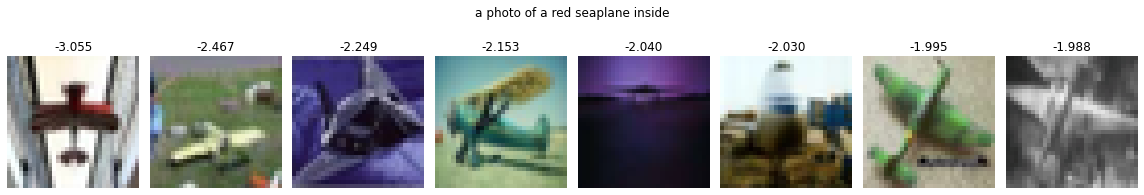

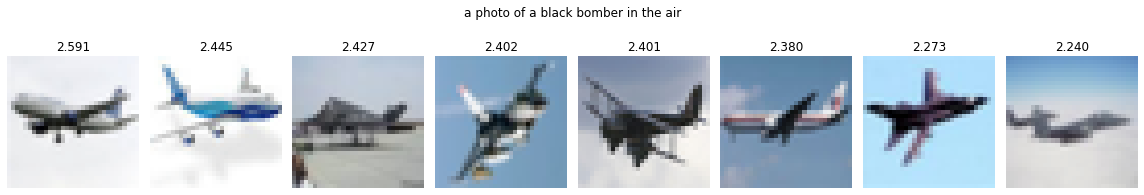



---


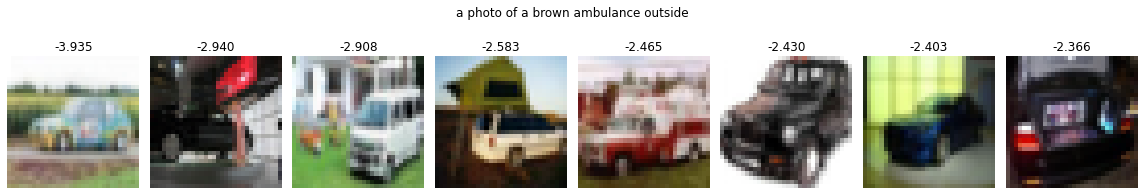

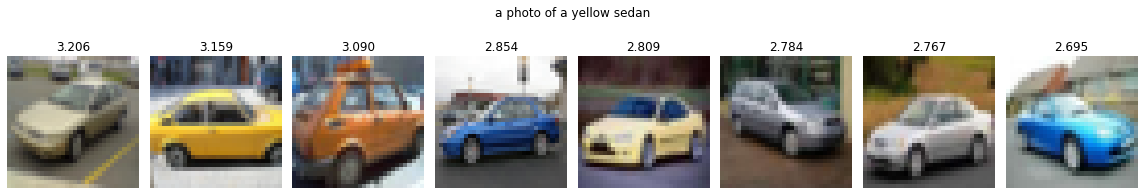



---


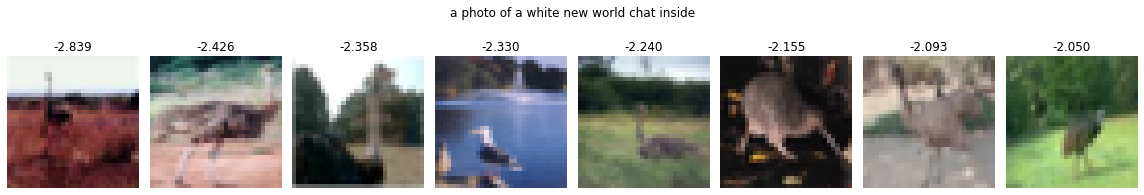

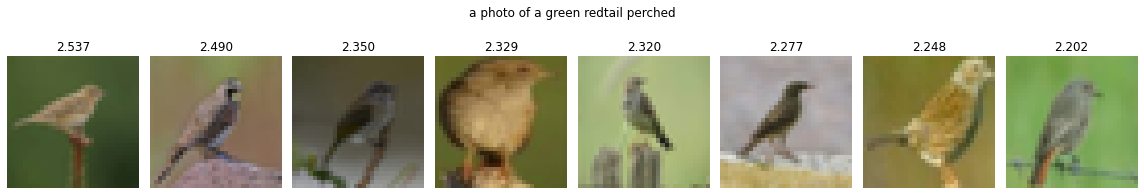



---


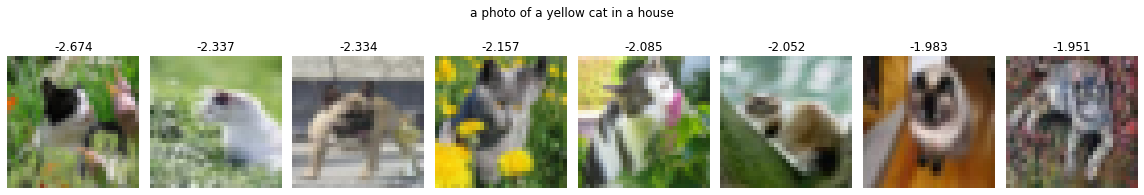

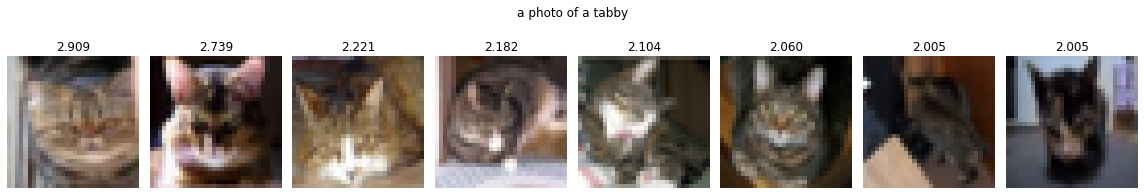



---


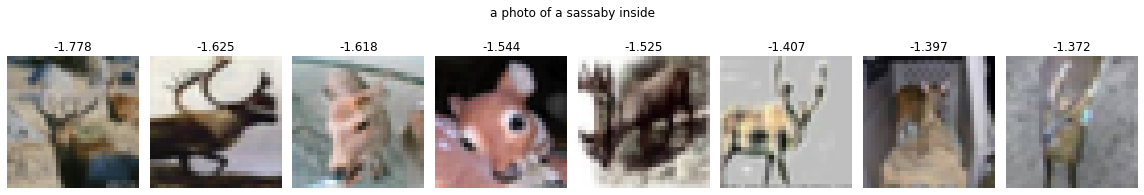

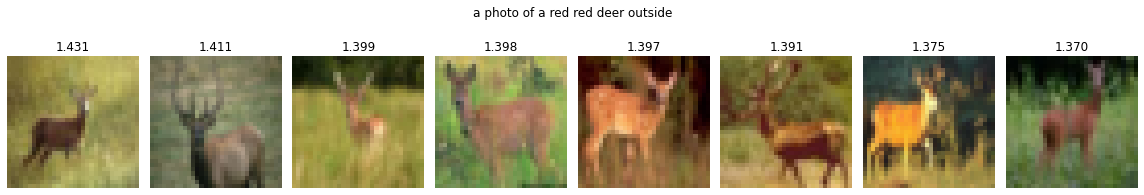



---


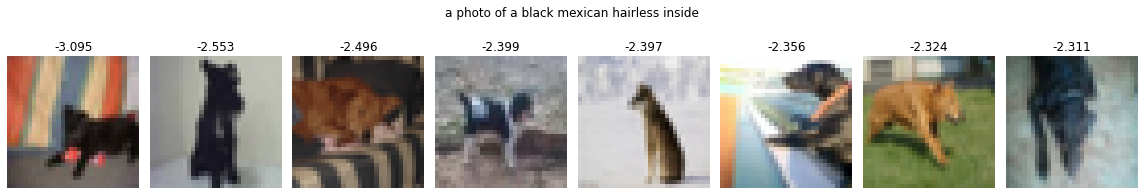

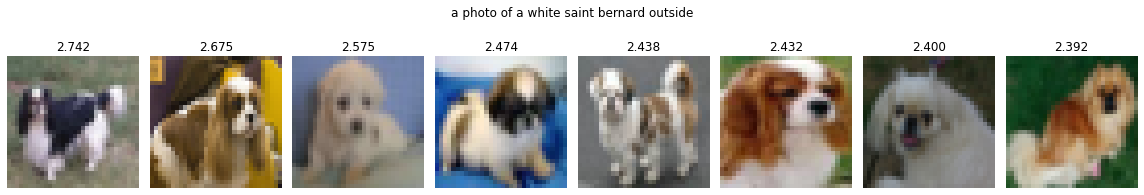



---


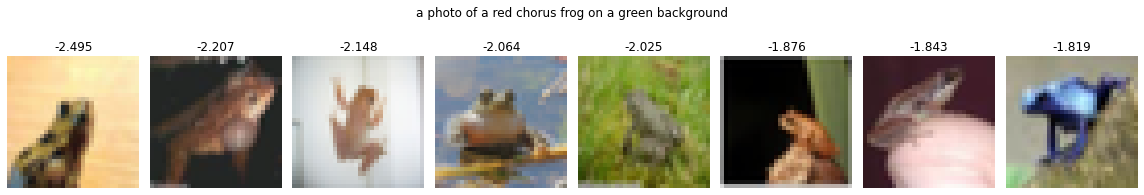

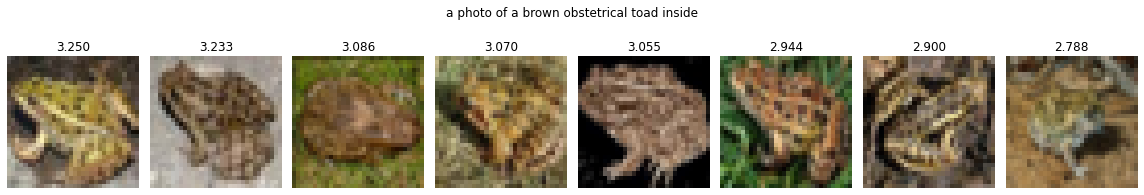



---


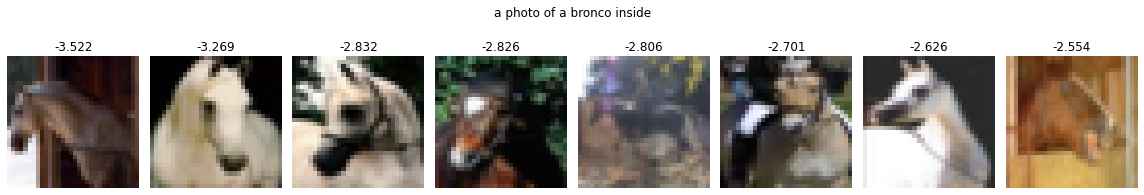

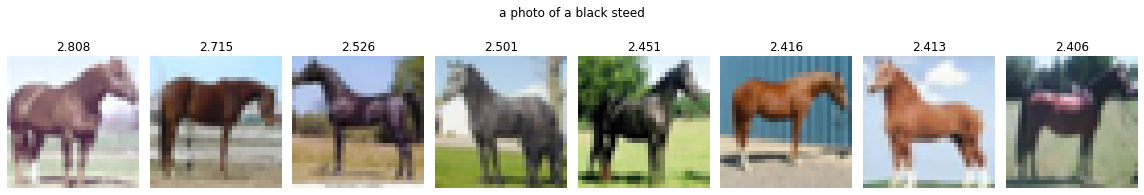



---


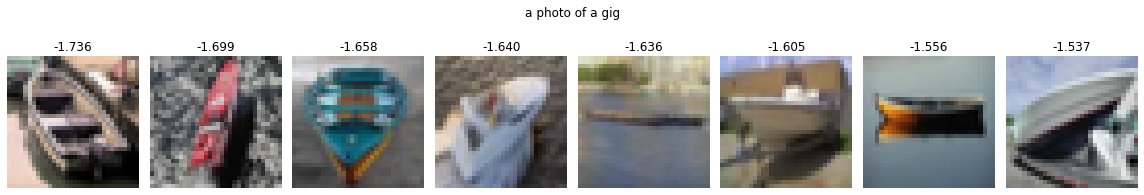

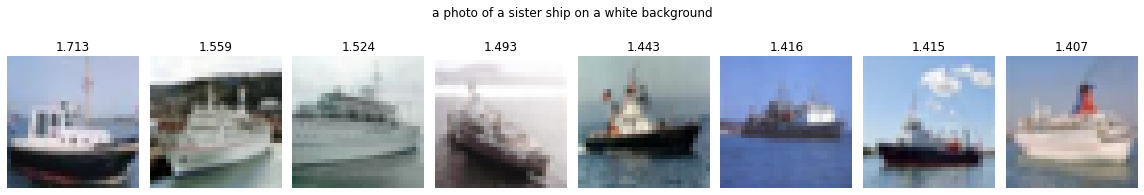



---


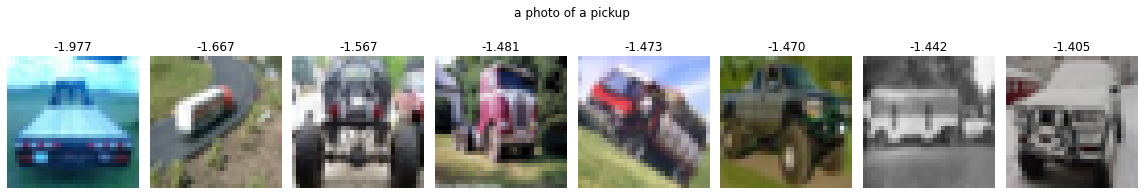

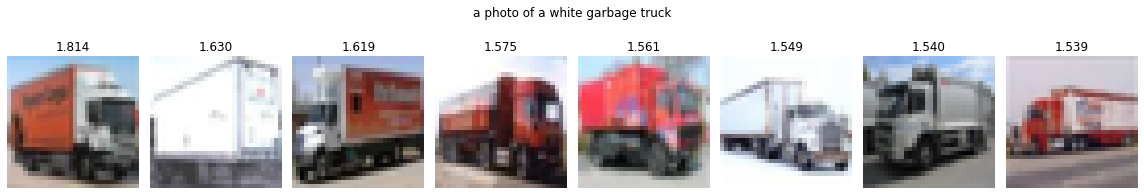

In [16]:

def visualize_images(ds, ds_indices, ds_values, K=8, title=""):
    fig, ax = plt.subplots(1, K, figsize=(K*2, 3))
    for i in range(K):
        idx = ds_indices[i]
        ax[i].imshow(TOIMAGE(ds[idx][0]))
        ax[i].axis(False)
        ax[i].set_title(f"{ds_values[i]:0.3f}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

gts = run_dict['test'][0]
for c in range(10):
    print("---")
    selected_caps = selected_captions[c]
    mask = gts == c
    masked_indices = np.arange(len(mask))[mask]
    dv = svm_decision_values['test'][mask]
    bottom_dv = np.argsort(dv)
    top_dv = bottom_dv[::-1]
    for order_name, order, cap in (
        ('bottom', bottom_dv, selected_caps[0]),
        ("top", top_dv, selected_caps[1]),
    ):
        vals = dv[order]
        visualize_images(test_ds, masked_indices[order], vals, title=cap)
        print("\n")
    

[('a photo of a white flying boat inside',
  'a photo of a black dive bomber on the tarmac'),
 ('a photo of a gas guzzler inside', 'a photo of a red sedan'),
 ('a photo of a white cacique in the air',
  'a photo of a brown adjutant bird outside'),
 ('a photo of a white cougar outside', 'a photo of a brown tabby'),
 ('a photo of a white sassaby inside', 'a photo of a wapiti outside'),
 ('a photo of a yellow yorkshire terrier outside',
  'a photo of a saint bernard inside'),
 ('a photo of a agua inside', 'a photo of a chameleon tree frog outside'),
 ('a photo of a prancer', 'a photo of a black quarter horse outside'),
 ('a photo of a black tin can inside',
  'a photo of a white racing gig outside'),
 ('a photo of a passenger van', 'a photo of a white delivery truck')]